In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [4]:
def load_data(notebook_name):
    " should be working in the same path "
    import os
    path= os.getcwd()
    print("currently working in "+ str(os.listdir()))
    path= os.getcwd()
    data = pd.read_csv(os.getcwd()+"//"+notebook_name)
    return data
data = load_data("data.csv") 

df = pd.DataFrame(data)
df.columns

currently working in ['.ipynb_checkpoints', '.vscode', 'data.csv', 'experiment.csv', 'flow.png', 'ml_copy-Copy1.ipynb', 'Modeling_assignment.ipynb', 'my_work.ipynb', 'rough.ipynb']


Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'document type', 'posting_id', 'area_business', 'total_open_amount',
       'baseline_create_date', 'cust_payment_terms', 'invoice_id', 'isOpen'],
      dtype='object')

In [5]:
df.shape

(50000, 19)

In [6]:
# As we can see in the list of columns 'document_create_date' is twice, so we drop one.

df_drop = df.drop(['document_create_date.1'], axis=1)

# finding nan values 
df_drop.isna().sum()

business_code               0
cust_number                 0
name_customer               0
clear_date              10000
buisness_year               0
doc_id                      0
posting_date                0
document_create_date        0
due_in_date                 0
invoice_currency            0
document type               0
posting_id                  0
area_business           50000
total_open_amount           0
baseline_create_date        0
cust_payment_terms          0
invoice_id                  6
isOpen                      0
dtype: int64

In [7]:
# From the above sum we can see 'area_business' is totally useless as it has null values for all 50k data rows.
df_drop1 = df_drop.drop(['area_business'], axis = 1)

# There are 4175 rows with clear date missing which is useful in finding payment delay predictions, so these rows are useless.
df_drop2 = df_drop1.dropna(axis = 0, how ='any') # additionally removing those 10 null values too for invoice_id
df_drop2.shape
# df_drop2.isna().sum()

(39994, 17)

## Creating our Target column

In [8]:
def change_date(x_type):
    x = int(x_type)
    x = str(x)
    year = int(x[0:4])
    month = int(x[4:6])
    day = int(x[6:])
    return dt.datetime(year, month, day)

In [9]:
# year/month/date
# due date() - clear date(day/month/year)
# generating due date into readable format.
df_drop2['due_date'] = df_drop2['due_in_date'].apply(change_date)
df_drop2['clear_date']= pd.to_datetime(df_drop2['clear_date']) 

# Creating target variable
df_drop2['target'] = (df_drop2['clear_date'] - df_drop2['due_date']).dt.days
# df_drop2.head(5) target value +ve means there was a delay in payment.

C:\Users\karti\AppData\Local\Temp\ipykernel_5532\987431143.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop2['due_date'] = df_drop2['due_in_date'].apply(change_date)
C:\Users\karti\AppData\Local\Temp\ipykernel_5532\987431143.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop2['clear_date']= pd.to_datetime(df_drop2['clear_date'])
C:\Users\karti\AppData\Local\Temp\ipykernel_5532\987431143.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [10]:
df_drop2.head(1)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,20200125,20200210.0,USD,RV,1.0,54273.28,20200126.0,NAH4,1.930438e+09,0,2020-02-10,1


## Training and Splitting the data

In [11]:
df_drop2['document_create_date'] = df_drop2['document_create_date'].apply(change_date)
df_drop2['baseline_create_date'] = df_drop2['baseline_create_date'].apply(change_date)

print(pd.to_datetime(df_drop2['document_create_date']).min()) 
print(pd.to_datetime(df_drop2['document_create_date']).max())

C:\Users\karti\AppData\Local\Temp\ipykernel_5532\452077917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop2['document_create_date'] = df_drop2['document_create_date'].apply(change_date)


2018-12-26 00:00:00
2020-03-02 00:00:00


C:\Users\karti\AppData\Local\Temp\ipykernel_5532\452077917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop2['baseline_create_date'] = df_drop2['baseline_create_date'].apply(change_date)


In [12]:
# Splitting the initial dataframe into train and test
# So in this case we can consider last 3 months for test set.
x_train = df_drop2[df_drop2['document_create_date'] <= '2020-01-01'].copy()
x_test = df_drop2[df_drop2['document_create_date'] > '2020-01-01'].copy()


In [13]:
print(x_train.shape)
print(x_test.shape)

(34971, 19)
(5023, 19)


In [14]:
x_train.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-07-22,20190811.0,USD,RV,1.0,79656.60,2019-07-22,NAD1,1.929646e+09,0,2019-08-11,-3
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-14,20190929.0,USD,RV,1.0,2253.86,2019-09-14,NAA8,1.929874e+09,0,2019-09-29,92
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-13,20191128.0,USD,RV,1.0,33133.29,2019-11-13,NAH4,1.930148e+09,0,2019-11-28,-3
5,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-09-20,20191004.0,CAD,RV,1.0,22225.84,2019-09-24,CA10,2.960581e+09,0,2019-10-04,61
6,U001,0200769623,WAL-MAR in,2019-11-12,2019.0,1.930083e+09,2019-11-01,2019-10-31,20191116.0,USD,RV,1.0,7358.49,2019-11-01,NAH4,1.930083e+09,0,2019-11-16,-4


## EDA and Feature Engineering

In [15]:
# business_code, invoice_currency, document type, posting_id, cust_payment_terms
print(dict(x_train['business_code'].value_counts()))
print(dict(x_test['business_code'].value_counts()))

{'U001': 31589, 'CA02': 2820, 'U013': 442, 'U002': 107, 'U005': 9, 'U007': 4}
{'U001': 4601, 'CA02': 354, 'U013': 59, 'U002': 9}


In [16]:
print(dict(x_train['invoice_currency'].value_counts()))
print(dict(x_test['invoice_currency'].value_counts()))

{'USD': 32149, 'CAD': 2822}
{'USD': 4669, 'CAD': 354}


In [17]:
print(dict(x_train['isOpen'].value_counts()))
print(dict(x_test['isOpen'].value_counts()))

{0: 34971}
{0: 5023}


In [18]:
print(dict(x_train['document type'].value_counts()))
print(dict(x_test['document type'].value_counts()))

{'RV': 34971}
{'RV': 5023}


In [19]:
print(dict(x_train['posting_id'].value_counts()))
print(dict(x_test['posting_id'].value_counts()))

{1.0: 34971}
{1.0: 5023}


In [20]:
print(dict(x_train['cust_payment_terms'].value_counts()))
# a little cramped but this gives the idea.
print()
print(dict(x_test['cust_payment_terms'].value_counts()))

{'NAA8': 14032, 'NAH4': 9267, 'CA10': 2727, 'NAC6': 1167, 'NAM4': 947, 'NAAX': 836, 'NAD1': 719, 'NAU5': 633, 'NAG2': 623, 'NAGD': 527, 'NA32': 526, 'NAX2': 469, 'NAM2': 418, 'NA10': 310, 'NAD5': 239, 'NAM1': 191, 'NAVE': 189, 'NAVF': 183, 'NAAW': 138, 'NAWU': 117, 'NAWN': 97, 'NAVR': 84, 'NAVQ': 75, 'NAWP': 48, 'CA30': 40, 'NAUZ': 37, 'NA3B': 36, 'NAVM': 31, 'NACB': 28, 'NA38': 23, 'NABG': 19, 'NAD4': 19, 'NAB1': 16, 'NAVD': 13, 'C106': 12, 'NA84': 12, 'NAVL': 11, 'BR56': 10, 'NAUP': 10, 'NA9X': 10, 'NA3F': 8, 'NATM': 7, 'NAM3': 6, 'CAB1': 6, 'CAX2': 5, 'NATJ': 5, 'NA25': 4, 'NAWM': 4, 'NATW': 4, 'B052': 3, 'NATH': 3, 'NAVC': 3, 'NA8Q': 3, 'NATL': 2, 'NAV9': 2, 'NATX': 2, '90M7': 2, 'NA31': 2, 'NATU': 1, 'NATK': 1, 'CA60': 1, 'NAUY': 1, 'NAUW': 1, 'NABD': 1, 'NATV': 1, 'MC15': 1, 'NAD8': 1, 'NAV2': 1, 'BR12': 1}

{'NAA8': 1984, 'NAH4': 1326, 'CA10': 342, 'NAM4': 165, 'NAC6': 150, 'NAAX': 126, 'NAGD': 119, 'NAG2': 100, 'NAD1': 100, 'NA32': 81, 'NAX2': 79, 'NAM2': 71, 'NAU5': 68, 'NA10'

In [21]:
x_train.describe()

,buisness_year,doc_id,due_in_date,posting_id,total_open_amount,invoice_id,isOpen,target
count,34971.000000,3.497100e+04,3.497100e+04,34971.0,34971.000000,3.497100e+04,34971.0,34971.000000
mean,2019.007492,2.013599e+09,2.019081e+07,1.0,32256.683147,2.013599e+09,0.0,0.861514
std,0.086232,2.805631e+08,1.094669e+03,0.0,39975.902056,2.805631e+08,0.0,10.711260
min,2019.000000,1.928502e+09,2.018122e+07,1.0,0.790000,1.928502e+09,0.0,-89.000000
25%,2019.000000,1.929101e+09,2.019042e+07,1.0,4714.295000,1.929101e+09,0.0,-3.000000
50%,2019.000000,1.929617e+09,2.019071e+07,1.0,17319.710000,1.929617e+09,0.0,0.000000
75%,2019.000000,1.930028e+09,2.019101e+07,1.0,46596.520000,1.930028e+09,0.0,2.000000
max,2020.000000,2.960605e+09,2.020030e+07,1.0,668593.360000,2.960605e+09,0.0,204.000000


In [22]:
# we get to see that posting_id and isOpen bboth have just one value for all data, so we remove them.
X_train = x_train.drop(['posting_id', 'posting_id', 'document type'], axis = 1)
X_test = x_test.drop(['posting_id', 'posting_id', 'document type'], axis = 1)

In [23]:
X_train.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-07-22,20190811.0,USD,79656.60,2019-07-22,NAD1,1.929646e+09,0,2019-08-11,-3
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-14,20190929.0,USD,2253.86,2019-09-14,NAA8,1.929874e+09,0,2019-09-29,92
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-13,20191128.0,USD,33133.29,2019-11-13,NAH4,1.930148e+09,0,2019-11-28,-3
5,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-09-20,20191004.0,CAD,22225.84,2019-09-24,CA10,2.960581e+09,0,2019-10-04,61
6,U001,0200769623,WAL-MAR in,2019-11-12,2019.0,1.930083e+09,2019-11-01,2019-10-31,20191116.0,USD,7358.49,2019-11-01,NAH4,1.930083e+09,0,2019-11-16,-4


<AxesSubplot:xlabel='business_code', ylabel='target'>

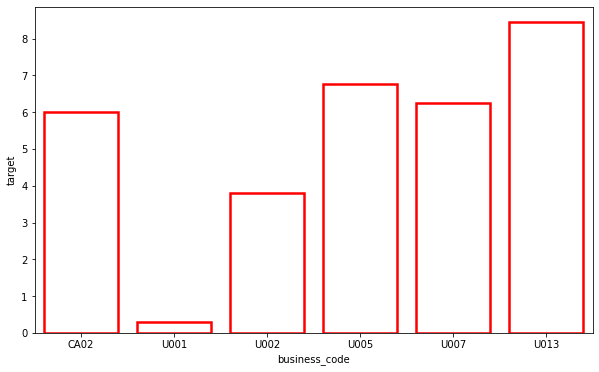

In [24]:
temp = pd.DataFrame(X_train.groupby(['business_code'], axis=0, as_index=False)['target'].mean())
plt.figure(figsize=(10,6))
sns.barplot(x="business_code", y="target",data=temp,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".4", edgecolor="red")

In [25]:
# The above graph shows that U005 and U013 code are the ones that delay their payments.

In [26]:
# Encoding the binary categorical column invoice_currency
X_train['invoice_currency'] = X_train['invoice_currency'].map({'USD': 0,'CAD': 1})
X_test['invoice_currency'] = X_test['invoice_currency'].map({'USD': 0,'CAD': 1})

<AxesSubplot:xlabel='invoice_currency', ylabel='target'>

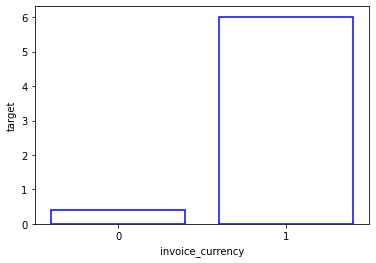

In [27]:
temp1 = pd.DataFrame(X_train.groupby(['invoice_currency'], axis=0, as_index=False)['target'].mean())
plt.figure(figsize=(6,4))
sns.barplot(x="invoice_currency", y="target",data=temp1,linewidth=1.5, facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor="blue")

In [28]:
# This shows USD currency deliveries have no delays in payment as such.

e:\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_open_amount', ylabel='Density'>

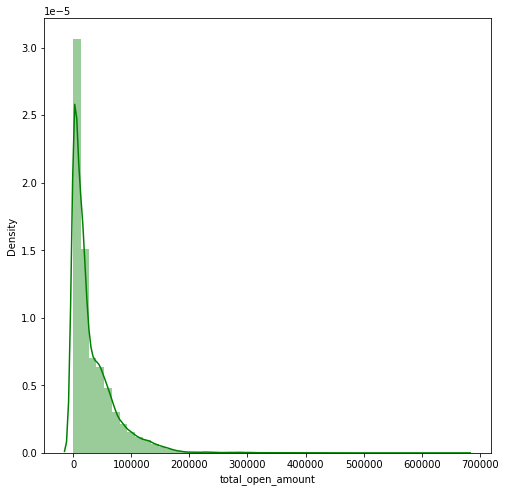

In [29]:
plt.figure(figsize=(8,8))
plt.figure(1)
sns.distplot(X_train['total_open_amount'],color='green')

In [30]:
# This shows the amount column is totally right skewed which puts strain on the bias of this data.

In [31]:
# Using log transformation to make it more 'normal' for better analysis
def Transform(x):
    return np.log(x)

X_train['total_open_amount'] = X_train['total_open_amount'].apply(Transform)
X_test['total_open_amount'] = X_test['total_open_amount'].apply(Transform)

In [32]:
X_train['cust_number'].nunique()

1294

In [33]:
# This pretty much doesnt give much info as its unique for each row
X_train['invoice_id'].nunique()

34228

In [34]:
# Dropping those columns which don't contribute anything for predictions.
X_train = X_train.drop(['buisness_year', 'due_in_date', 'isOpen'], axis = 1)
X_test = X_test.drop(['buisness_year', 'due_in_date', 'isOpen'], axis = 1)

In [35]:
X_train.head(1)

,business_code,cust_number,name_customer,clear_date,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,due_date,target
1,U001,0200980828,BEN E,2019-08-08,1.929646e+09,2019-07-22,2019-07-22,0,11.28548,2019-07-22,NAD1,1.929646e+09,2019-08-11,-3


e:\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target', ylabel='Density'>

<Figure size 432x432 with 0 Axes>

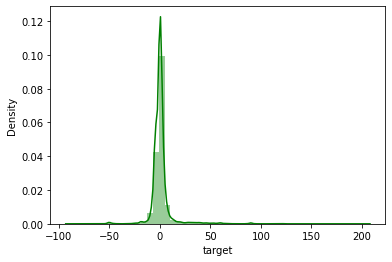

In [36]:
plt.figure(figsize=(6,6))
plt.figure(2)
sns.distplot(X_train['target'],color='green')

In [37]:
# This is pretty much symmetric meaning normalised already.

In [38]:
#print(dict(X_train['cust_number'].value_counts()))
def integers(x):
    ref = dict(X_train['cust_number'].value_counts())
    if ref.get(x):
        return ref[x]

X_train['cust_number'] = X_train['cust_number'].apply(integers)

In [39]:
def integers_test(x):
    ref = dict(X_test['cust_number'].value_counts())
    if ref.get(x):
        return ref[x]
    
X_test['cust_number'] = X_test['cust_number'].apply(integers_test)

In [40]:
X_train.head(3)

,business_code,cust_number,name_customer,clear_date,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,due_date,target
1,U001,50,BEN E,2019-08-08,1.929646e+09,2019-07-22,2019-07-22,0,11.285480,2019-07-22,NAD1,1.929646e+09,2019-08-11,-3
2,U001,132,MDV/ trust,2019-12-30,1.929874e+09,2019-09-14,2019-09-14,0,7.720400,2019-09-14,NAA8,1.929874e+09,2019-09-29,92
4,U001,7763,WAL-MAR foundation,2019-11-25,1.930148e+09,2019-11-13,2019-11-13,0,10.408294,2019-11-13,NAH4,1.930148e+09,2019-11-28,-3


In [41]:
# It is clear that U002 afterwards all business codes are meager so we take it as others.

X_train = X_train.replace(['U002', 'U005', 'U007'], 'other')
X_test = X_test.replace(['U002', 'U005', 'U007'], 'other')

business = pd.get_dummies(X_train['business_code'])
business1 = pd.get_dummies(X_test['business_code'])
# Above in the business_code column we can see they are categorical ones, so we make new feature
# out of them 
X_train = pd.concat([X_train, business], axis=1)
X_test = pd.concat([X_test, business1], axis=1)

X_train.head()

,business_code,cust_number,name_customer,clear_date,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,due_date,target,CA02,U001,U013,other
1,U001,50,BEN E,2019-08-08,1.929646e+09,2019-07-22,2019-07-22,0,11.285480,2019-07-22,NAD1,1.929646e+09,2019-08-11,-3,0,1,0,0
2,U001,132,MDV/ trust,2019-12-30,1.929874e+09,2019-09-14,2019-09-14,0,7.720400,2019-09-14,NAA8,1.929874e+09,2019-09-29,92,0,1,0,0
4,U001,7763,WAL-MAR foundation,2019-11-25,1.930148e+09,2019-11-13,2019-11-13,0,10.408294,2019-11-13,NAH4,1.930148e+09,2019-11-28,-3,0,1,0,0
5,CA02,77,THE corporation,2019-12-04,2.960581e+09,2019-09-20,2019-09-20,1,10.009011,2019-09-24,CA10,2.960581e+09,2019-10-04,61,1,0,0,0
6,U001,7763,WAL-MAR in,2019-11-12,1.930083e+09,2019-11-01,2019-10-31,0,8.903610,2019-11-01,NAH4,1.930083e+09,2019-11-16,-4,0,1,0,0


In [42]:
# creating a new feature from baseline column.
X_train['baseline_quater']= pd.to_datetime(X_train['baseline_create_date']).dt.quarter
X_test['baseline_quater']= pd.to_datetime(X_test['baseline_create_date']).dt.quarter


In [43]:
X_train = X_train.replace(['NAA8', 'NAAX', 'NAAW'], 'NAA')
X_train = X_train.replace(['NAGD', 'NAUZ', 'NAVF', 'NAVE', 'NAVR', 'NAWN', 'NAVQ',
                                  'NAWP', 'NAVM', 'NACB', 'NABG','NAVD', 'NAVL', 'NAUP', 'NATJ', 'NATH', 
                                  'NATU', 'NA8Q', 'NAVC', 'NANC', 'NATK', 'NAUI', 'NAWM',
                                  'NATL', 'NAUY', 'NATW', 'NATX', 'NAWU'], 'NA_place')

X_train = X_train.replace(['NAH4', 'NAC6', 'NAM4', 'NAD1', 'NAU5', 'NAG2', 'NAX2', 'NAD5', 'NAM1',
                                  'NAD4','NAB1','NAM2','NAM3', 'NAV9',  'NAV2', 'NAD8'], 'NA_letter_number')

X_train = X_train.replace(['NA3B', 'NA3F', 'NA9X'], 'NA_number_letter')

X_train = X_train.replace(['NA32', 'NA10', 'NA38', 'NA84', 'NA25', 'NA31'], 'NA_number_number')

X_train = X_train.replace(['CA10', 'CA30', 'C106', 'CAX2', 'CAB1', 'C129', 'CA60'], 'CA')

X_train = X_train.replace(['C106', 'C129', '90M7'], 'C_number')

X_train = X_train.replace(['BR56', 'B030', 'B052', 'BR12', 'B112'], 'B')

X_train['cust_payment_terms'].value_counts()

NAA                 15006
NA_letter_number    14718
CA                   2791
NA_place             1498
NA_number_number      877
NA_number_letter       54
B                      14
NATM                    7
C_number                2
NATV                    1
NAUW                    1
NABD                    1
MC15                    1
Name: cust_payment_terms, dtype: int64

In [44]:
X_test = X_test.replace(['NAA8', 'NAAX', 'NAAW'], 'NAA')

X_test = X_test.replace(['NAGD', 'NAUZ', 'NAVF', 'NAVE', 'NAVR', 'NAWN', 'NAVQ',
                                  'NAWP', 'NAVM', 'NACB', 'NABG','NAVD', 'NAVL', 'NAUP', 'NATJ', 'NATH', 
                                  'NATU', 'NA8Q', 'NAVC', 'NANC', 'NATK', 'NAUI', 'NAWM',
                                  'NATL', 'NAUY', 'NATZ', 'NACE', 'NATZ'], 'NA_place')

X_test = X_test.replace(['NAH4', 'NAC6', 'NAM4', 'NAD1', 'NAU5', 'NAG2', 'NAX2', 'NAD5', 'NAM1',
                                  'NAD4','NAB1','NAM2','NAM3', 'NAV9',  'NAV2', 'NAD8'], 'NA_letter_number')

X_test = X_test.replace(['NA3B', 'NA3F', 'NA9X'], 'NA_number_letter')

X_test = X_test.replace(['NA32', 'NA10', 'NA38', 'NA84', 'NA25', 'NA31'], 'NA_number_number')

X_test = X_test.replace(['CA10', 'CA30', 'C106', 'CAX2', 'CAB1', 'C129', 'CA60'], 'CA')

X_test = X_test.replace(['C106', 'C129', '90M7'], 'C_number')

X_test = X_test.replace(['BR56', 'B030', 'B052'], 'B')

X_test['cust_payment_terms'].value_counts()

NA_letter_number    2147
NAA                 2131
CA                   349
NA_place             238
NA_number_number     146
NA_number_letter       8
C_number               3
BR12                   1
Name: cust_payment_terms, dtype: int64

In [45]:
# See however a discrepency has occurred i.e. there is no column of B
# so we just add a column B with values 0.
X_test['B'] = np.zeros(5023)
X_test.head(3)

,business_code,cust_number,name_customer,clear_date,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,due_date,target,CA02,U001,U013,other,baseline_quater,B
0,U001,1179,WAL-MAR corp,2020-02-11,1.930438e+09,2020-01-26,2020-01-25,0,10.901787,2020-01-26,NA_letter_number,1.930438e+09,2020-02-10,1,0,1,0,0,1,0.0
19,U001,1179,WAL-MAR systems,2020-02-05,1.930438e+09,2020-01-24,2020-01-24,0,10.884621,2020-01-24,NA_letter_number,1.930438e+09,2020-02-08,-3,0,1,0,0,1,0.0
20,U013,3,SYSTEMS systems,2020-02-11,1.991838e+09,2020-01-11,2020-01-07,0,8.645323,2020-01-11,NA_place,1.991838e+09,2020-02-10,1,0,0,1,0,1,0.0


In [46]:
payment = pd.get_dummies(X_train['cust_payment_terms'])
payment1 = pd.get_dummies(X_test['cust_payment_terms'])

# Above in the cust_payment_terms column we can see they are categorical ones, so we make new feature
# out of them 
X_final = pd.concat([X_train, payment], axis=1)
X_final_test = pd.concat([X_test, payment1], axis=1)

X_final.head(1)

,business_code,cust_number,name_customer,clear_date,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,baseline_create_date,...,MC15,NAA,NABD,NATM,NATV,NAUW,NA_letter_number,NA_number_letter,NA_number_number,NA_place
1,U001,50,BEN E,2019-08-08,1.929646e+09,2019-07-22,2019-07-22,0,11.28548,2019-07-22,...,0,0,0,0,0,0,1,0,0,0


In [47]:
# X_final_test.head(15)

In [48]:
X_final.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date', 'doc_id',
       'posting_date', 'document_create_date', 'invoice_currency',
       'total_open_amount', 'baseline_create_date', 'cust_payment_terms',
       'invoice_id', 'due_date', 'target', 'CA02', 'U001', 'U013', 'other',
       'baseline_quater', 'B', 'CA', 'C_number', 'MC15', 'NAA', 'NABD', 'NATM',
       'NATV', 'NAUW', 'NA_letter_number', 'NA_number_letter',
       'NA_number_number', 'NA_place'],
      dtype='object')

<AxesSubplot:>

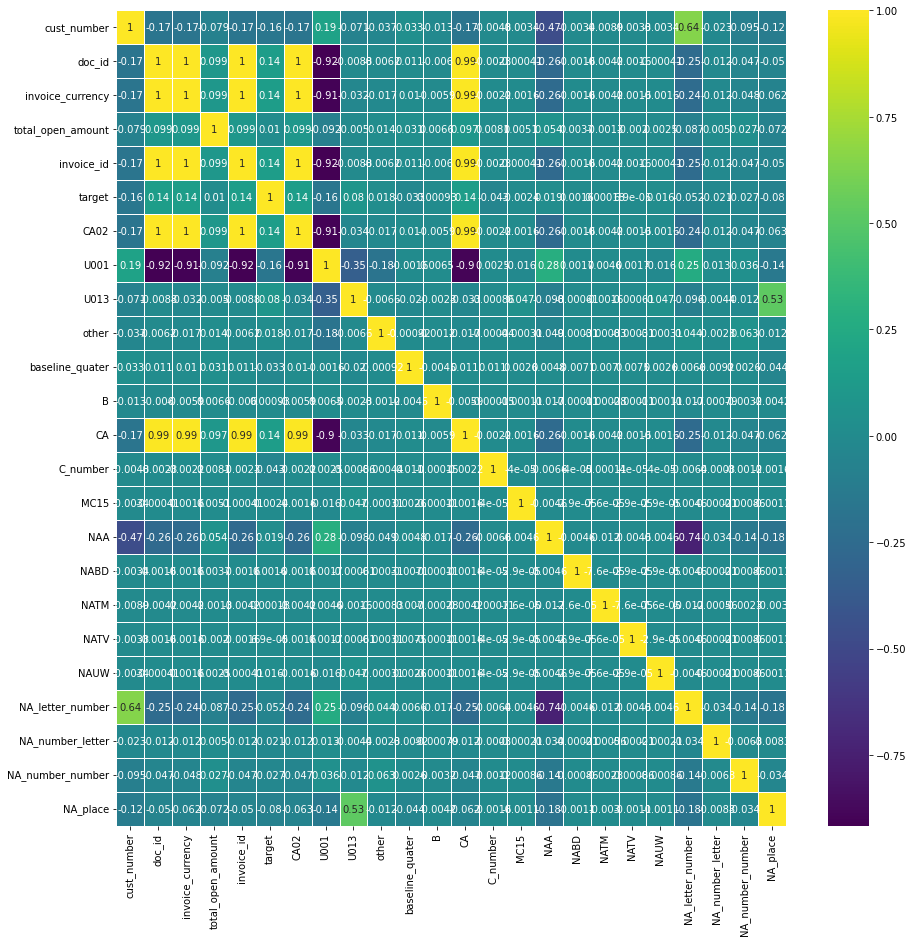

In [49]:
# X_final.columns
plt.figure(figsize=(15,15))
sns.heatmap(X_final.corr(),annot=True,cmap='viridis',linewidths=.5)

In [50]:
# dropping columns that won't help in predictions. Note on feature has high correlation with target variable.
X_final = X_final.drop(['doc_id', 'invoice_id','business_code', 'name_customer', 'clear_date',
                       'posting_date', 'document_create_date', 'baseline_create_date', 'cust_payment_terms',
                       'invoice_id', 'due_date'], axis = 1)

X_final_test = X_final_test.drop(['doc_id', 'invoice_id','business_code', 'name_customer', 'clear_date',
                       'posting_date', 'document_create_date', 'baseline_create_date', 'cust_payment_terms',
                       'invoice_id', 'due_date'], axis = 1)

In [51]:
X_final.head(1)

,cust_number,invoice_currency,total_open_amount,target,CA02,U001,U013,other,baseline_quater,B,...,MC15,NAA,NABD,NATM,NATV,NAUW,NA_letter_number,NA_number_letter,NA_number_number,NA_place
1,50,0,11.28548,-3,0,1,0,0,3,0,...,0,0,0,0,0,0,1,0,0,0


<AxesSubplot:>

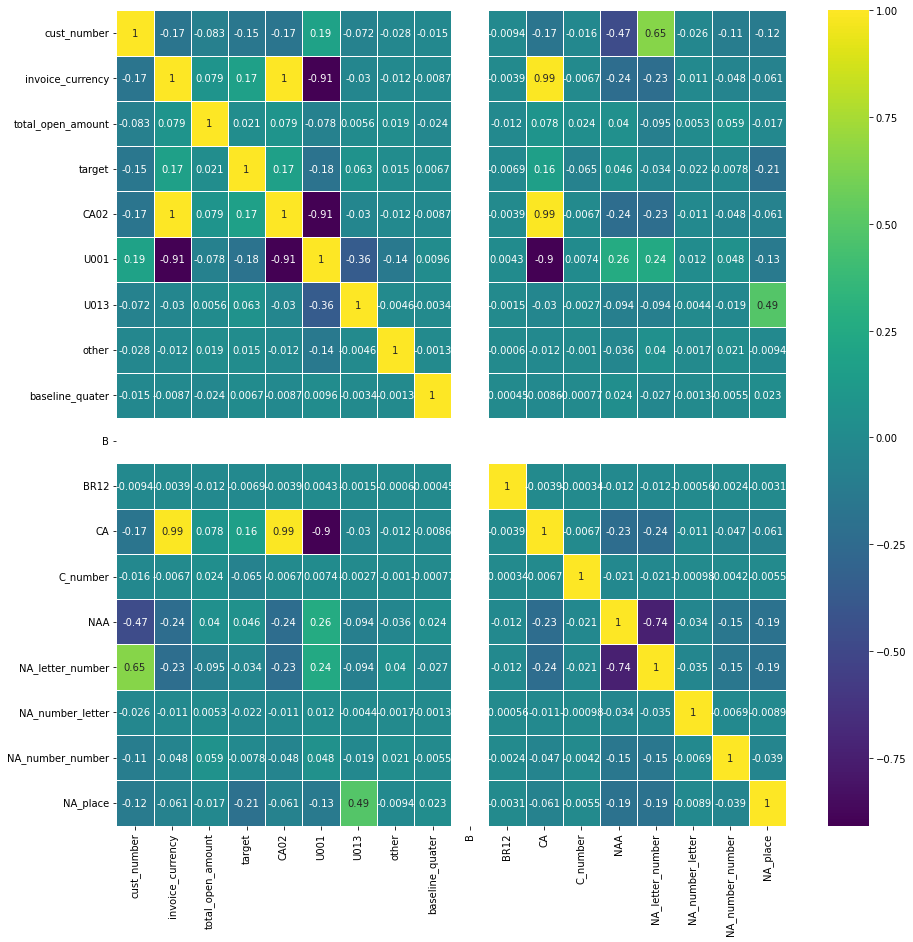

In [53]:
# X_final.columns
plt.figure(figsize=(15,15))
sns.heatmap(X_final_test.corr(),annot=True,cmap='viridis',linewidths=.5)

## Training and splitting

In [91]:
y = X_final['target']
X_final = X_final.drop(['target'], axis = 1)
Xtrain ,Xtest, ytrain, ytest = train_test_split(X_final, y, test_size = 0.2, random_state=0)

In [92]:
l = list(np.isfinite(ytrain))
print([x for x in l if x == False])

[]


In [93]:
lp = list(np.isfinite(Xtrain))
print([x for x in lp if x == False])

[]


In [130]:
random_model = RandomForestRegressor(n_estimators=500)

# <B>asdasdadad </B>

<b> --------------------------------- </b>

In [131]:
#Fit
random_model.fit(Xtrain, ytrain)

y_pred3 = random_model.predict(Xtest)

#Checking the accuracy
random_model_accuracy = round(random_model.score(Xtrain, ytrain)*100,2)
print(round(random_model_accuracy,2),'%')

90.01 %


In [132]:
random_model_accuracy1 = round(random_model.score(Xtest, ytest)*100,2)
print(round(random_model_accuracy1, 2), '%')

37.77 %


In [122]:
X_final_test = X_final_test.drop(['target'], axis = 1)

ValueError: No axis named 1 for object type Series

In [97]:
X_final_test[:15]

,cust_number,invoice_currency,total_open_amount,CA02,U001,U013,other,baseline_quater,B,BR12,CA,C_number,NAA,NA_letter_number,NA_number_letter,NA_number_number,NA_place
0,1179,0,10.901787,0,1,0,0,1,0.0,0,0,0,0,1,0,0,0
19,1179,0,10.884621,0,1,0,0,1,0.0,0,0,0,0,1,0,0,0
20,3,0,8.645323,0,0,1,0,1,0.0,0,0,0,0,0,0,0,1
24,1179,0,9.333246,0,1,0,0,1,0.0,0,0,0,0,1,0,0,0
41,1179,0,8.507916,0,1,0,0,1,0.0,0,0,0,0,1,0,0,0
42,18,0,10.909876,0,1,0,0,1,0.0,0,0,0,1,0,0,0,0
43,1179,0,8.079658,0,1,0,0,1,0.0,0,0,0,0,1,0,0,0
48,1179,0,10.814241,0,1,0,0,1,0.0,0,0,0,0,1,0,0,0
54,2,0,9.441985,0,1,0,0,1,0.0,0,0,0,1,0,0,0,0
55,5,0,10.149604,0,1,0,0,1,0.0,0,0,0,1,0,0,0,0


In [98]:
X_final_test.isna().sum()



cust_number          0
invoice_currency     0
total_open_amount    0
CA02                 0
U001                 0
U013                 0
other                0
baseline_quater      0
B                    0
BR12                 0
CA                   0
C_number             0
NAA                  0
NA_letter_number     0
NA_number_letter     0
NA_number_number     0
NA_place             0
dtype: int64

In [99]:
X_final_test = X_final_test['cust_number'].fillna(value=0)

In [108]:
X_final_test.columns

AttributeError: 'Series' object has no attribute 'columns'

In [117]:
random_model
X_test_mod= np.array(X_final_test)
X_test_mod= X_test_mod.reshape(-1, 1)

In [126]:
#wrong answer


#real_time_data = random_model.predict(X_final)

In [127]:
real_time_data

array([-2.37000000e+00,  5.83225000e+01, -3.09000000e+00, ...,
        1.56433333e+00,  1.00000000e-02, -4.65250000e+00])

In [120]:
real_time_data = random_model.predict(X_final_test)


e:\conda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[1179. 1179.    3. ...   71.  234.   27.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
def Mapping(x):
    temp = []
    for i in list(x):
        if i < 0:
            temp.append("Payment done before due date.")
        elif i > 15:
            temp.append("Payment done 15 days after due date.")
        elif i > 30:
            temp.append("Payment done 30 days after due date.")
        else:
            temp.append("Payment done much after due date.")
    return temp

col2 = Mapping(real_time_data)
bucket = pd.DataFrame()
bucket['Predictions'] = real_time_data
bucket['Bucket_list'] = col2
bucket.head()

In [123]:
X_final[:5]

,cust_number,invoice_currency,total_open_amount,CA02,U001,U013,other,baseline_quater,B,CA,...,MC15,NAA,NABD,NATM,NATV,NAUW,NA_letter_number,NA_number_letter,NA_number_number,NA_place
1,50,0,11.285480,0,1,0,0,3,0,0,...,0,0,0,0,0,0,1,0,0,0
2,132,0,7.720400,0,1,0,0,3,0,0,...,0,1,0,0,0,0,0,0,0,0
4,7763,0,10.408294,0,1,0,0,4,0,0,...,0,0,0,0,0,0,1,0,0,0
5,77,1,10.009011,1,0,0,0,3,0,1,...,0,0,0,0,0,0,0,0,0,0
6,7763,0,8.903610,0,1,0,0,4,0,0,...,0,0,0,0,0,0,1,0,0,0


In [125]:
X_final_test

0        1179
19       1179
20          3
24       1179
41       1179
         ... 
49955      47
49957     234
49989      71
49993     234
49997      27
Name: cust_number, Length: 5023, dtype: int64